In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [3]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [4]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

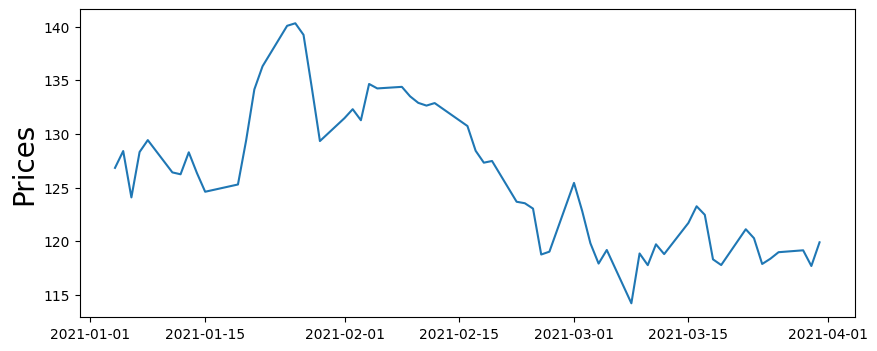

In [5]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

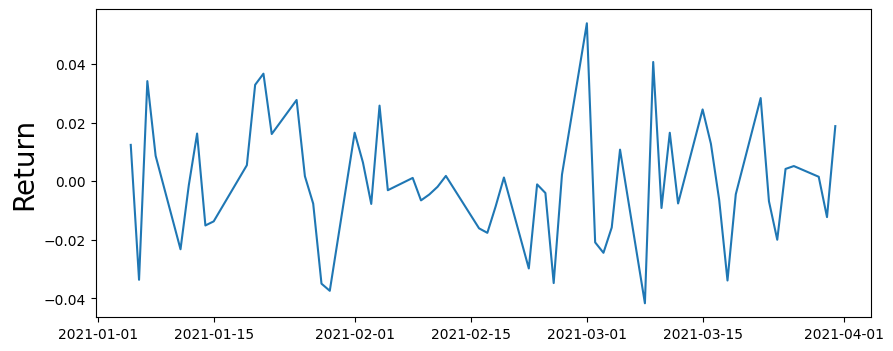

In [6]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

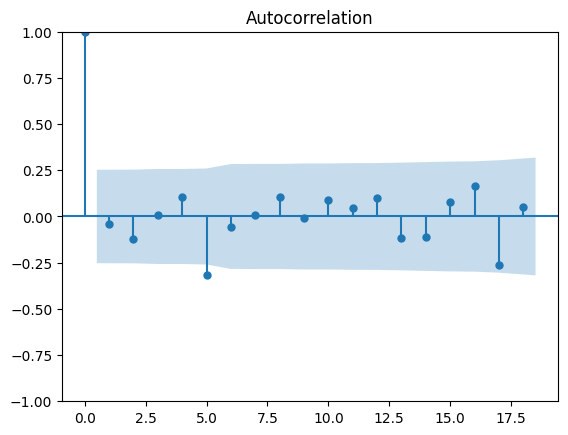

In [7]:
plot_acf(returns)
plt.show()

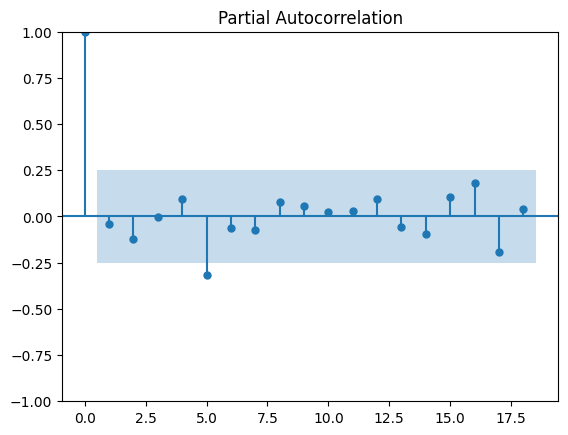

In [8]:
plot_pacf(returns)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 8359.17it/s]


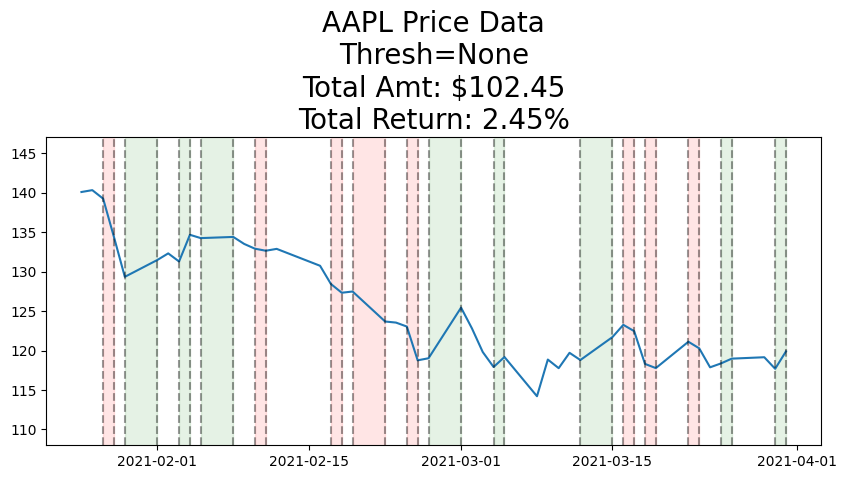

102.44859267116122

In [9]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [10]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<?, ?it/s]


C:\Users\Nishita\AppData\Local\Temp\ipykernel_40748\2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)
C:\Users\Nishita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nishita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', Tr

Text(0.5, 1.0, 'Avg: $94.95\nSD: $6.58')

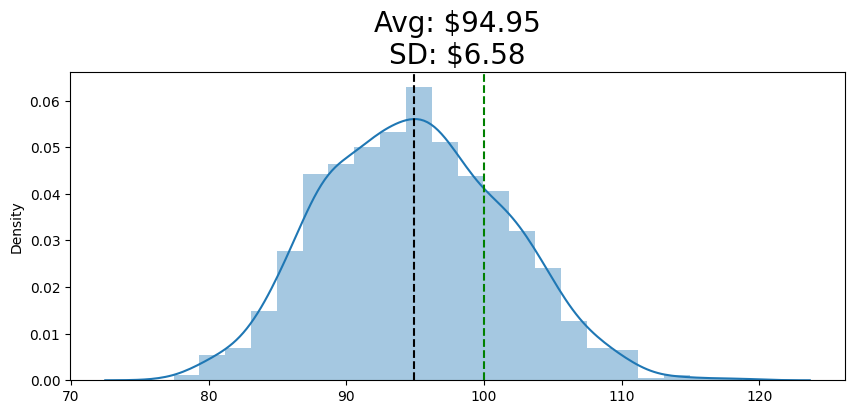

In [11]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

  0%|                                                                                           | 0/46 [00:00<?, ?it/s]C:\Users\Nishita\AppData\Local\Temp\ipykernel_40748\2958298199.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or (order == 'last' and curr_data[-1] > 0)):
100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 6157.07it/s]


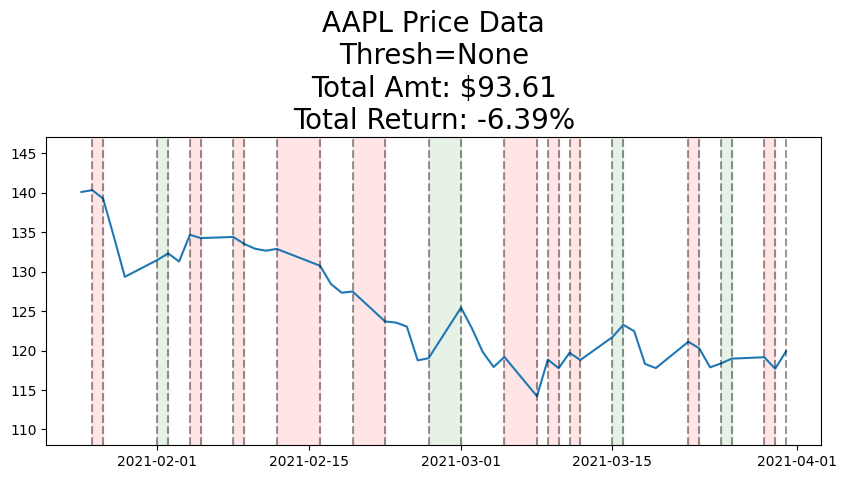

93.60988349206855

In [12]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 10954.29it/s]


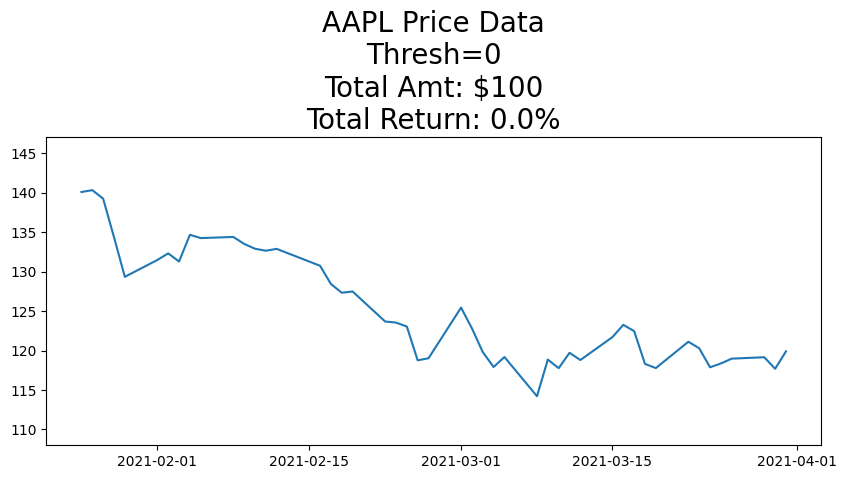

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 7324.90it/s]


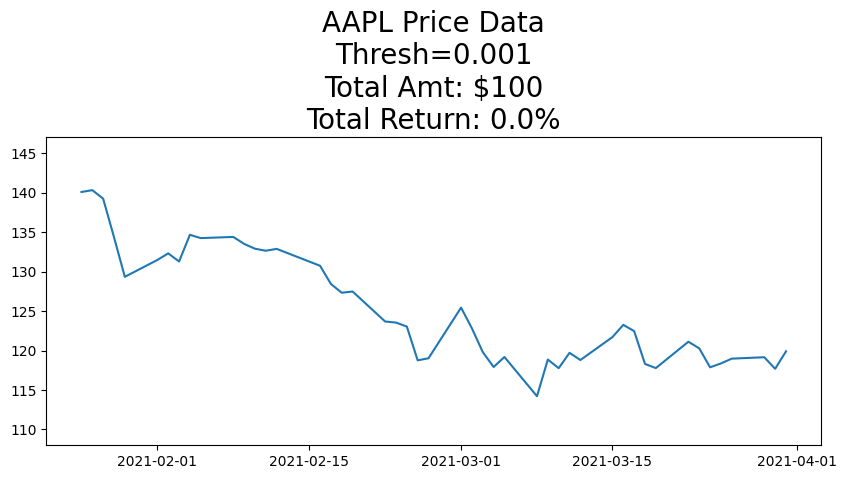

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 7922.56it/s]


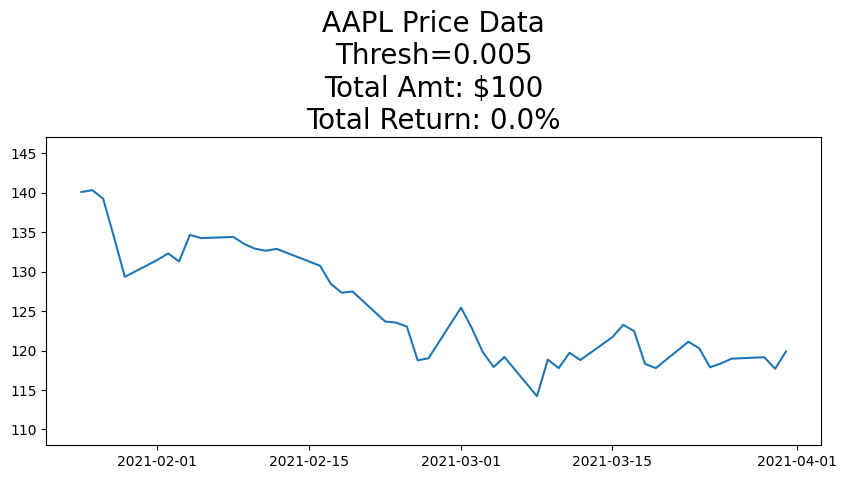

In [13]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 6142.37it/s]


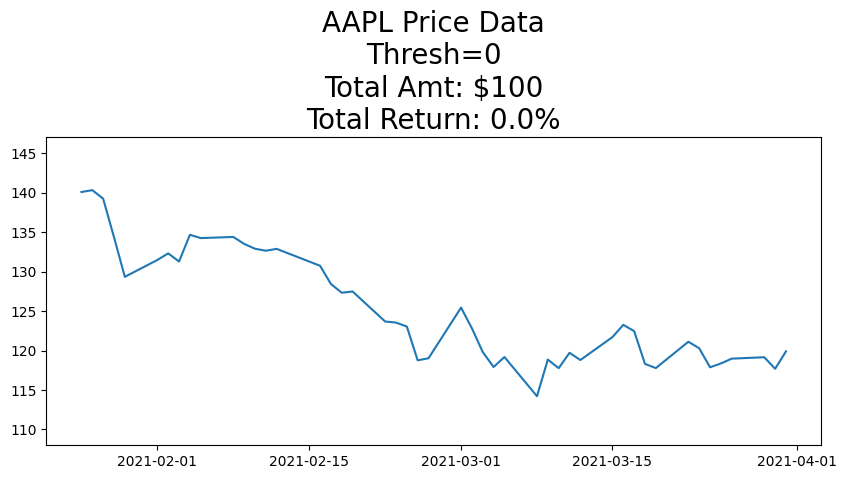

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 6853.92it/s]


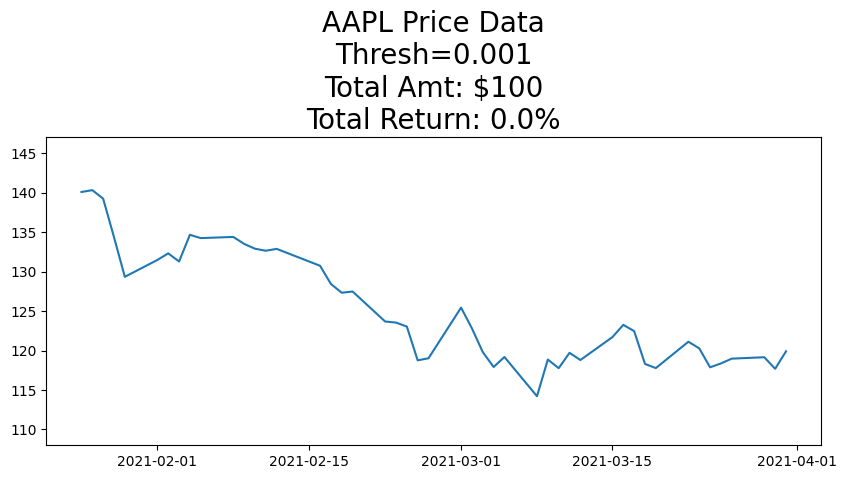

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 5149.82it/s]


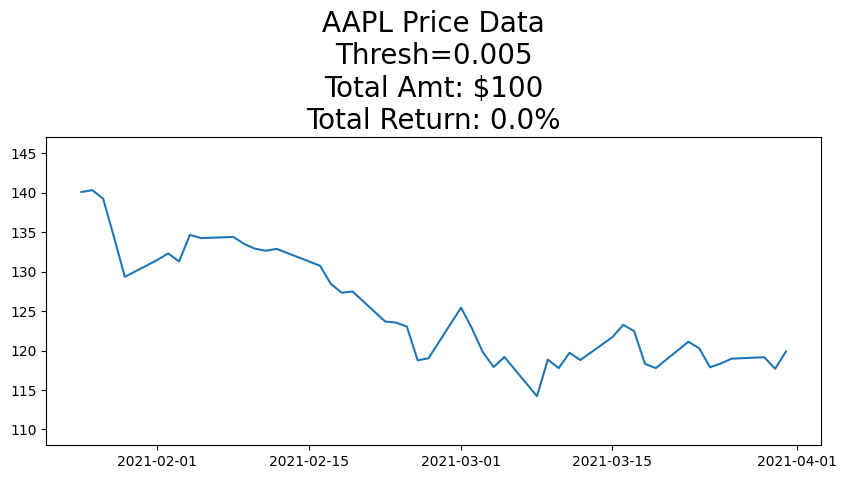

In [14]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 6267.88it/s]


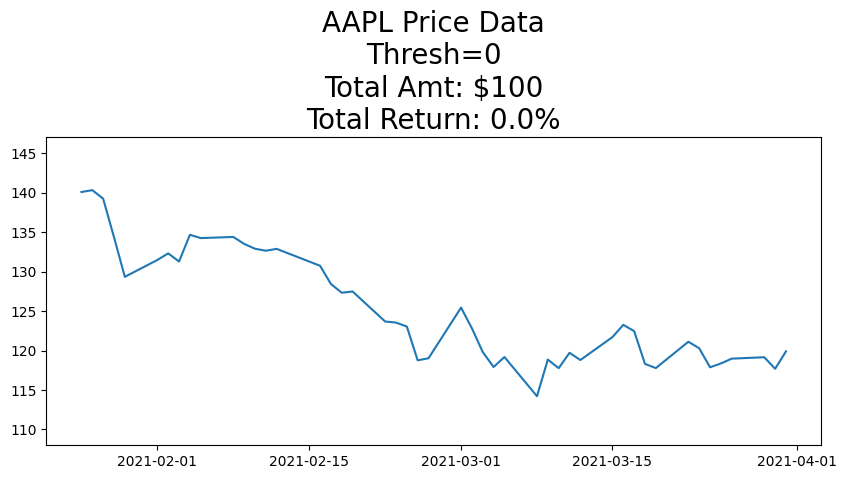

100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 8829.71it/s]


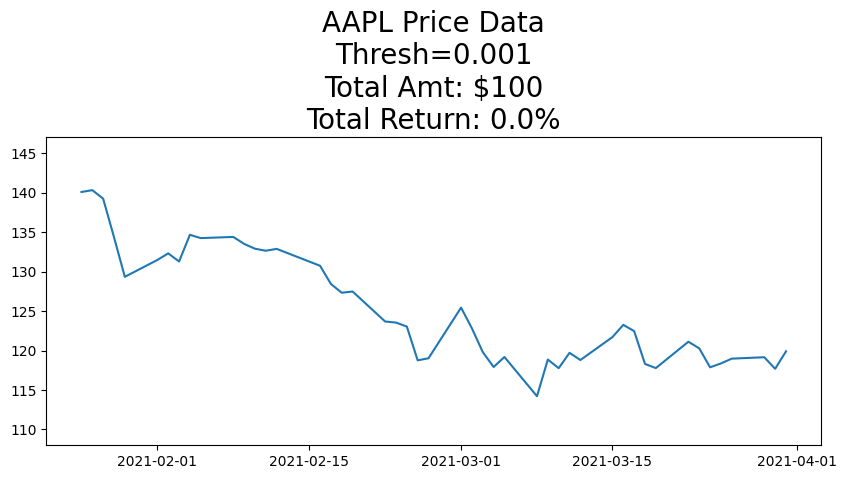

100%|███████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 11934.06it/s]


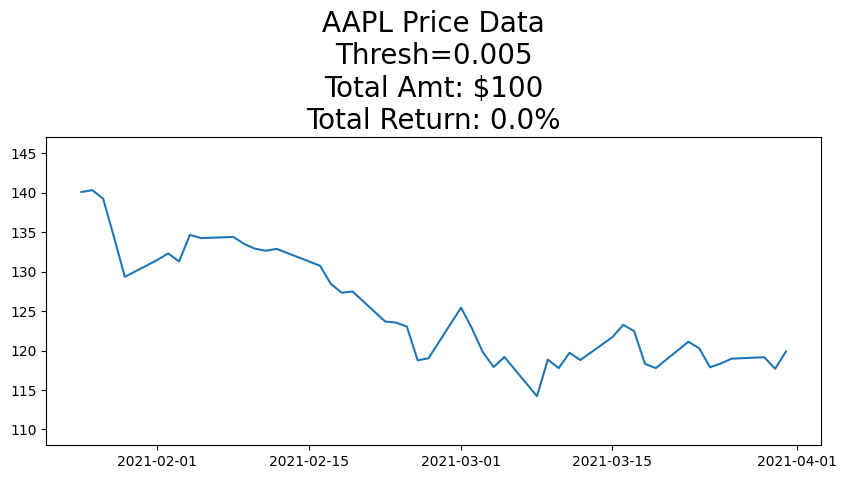

In [15]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)